In [85]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications import VGG16

from sklearn.metrics import confusion_matrix
main_path = "C:\\Users\\munod\\OneDrive\\Documents\\Datasets\\BreastUltrasound\\Dataset_BUSI_with_GT"
directories = os.listdir(main_path)
images = []
labels = []
for direct in directories:
    #print(direct)
    files = os.listdir(main_path+"\\"+direct)
    if direct == "normal":
        code = 0
    elif direct == "benign":
        code = 1
    else:
        code = 2
    for file in files:
        if not file.endswith("_mask.png"):
            img = cv2.imread(main_path+"\\"+direct+"\\"+file)
            img = cv2.resize(img, (400,400))
            label_array = [0,0,0]
            label_array[code] = 1
            labels.append(label_array)
            images.append(img)


In [86]:
images = np.asarray(images)
labels = np.asarray(labels)
display("Shape of Images" , images.shape, "Label Shape", labels.shape)

'Shape of Images'

(798, 400, 400, 3)

'Label Shape'

(798, 3)

In [87]:
data = images/255.0

In [88]:
X_train,X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True)


In [89]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(400, 400, 3))

In [90]:
num_classes = 3

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [91]:
for layer in model.layers[:-3]:
    layer.trainable = False

In [92]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [93]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 292s 14s/step - accuracy: 0.4159 - loss: 8.5447
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 285s 14s/step - accuracy: 0.6267 - loss: 1.0827
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 284s 14s/step - accuracy: 0.7985 - loss: 0.4903
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 286s 14s/step - accuracy: 0.8784 - loss: 0.3158
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 306s 15s/step - accuracy: 0.9449 - loss: 0.2081
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 301s 15s/step - accuracy: 0.9597 - loss: 0.1762
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 299s 15s/step - accuracy: 0.9838 - loss: 0.1204
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 318s 16s/step - accuracy: 0.9909 - loss: 0.0846
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 337s 17s/step - accuracy: 0.9847 - loss: 0.1021
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 299s 15s/step - accuracy: 0.9878 - loss: 0.0841


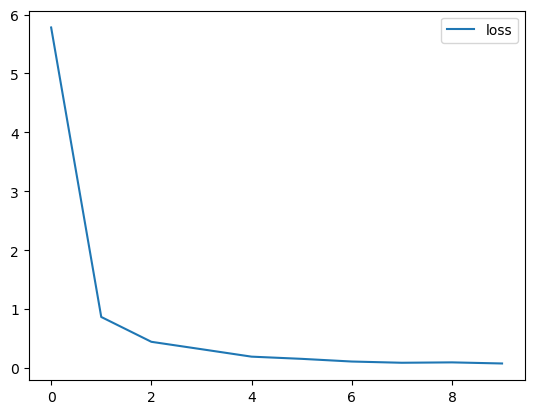

In [94]:
plt.plot(model.history.history['loss'], label='loss')
plt.legend()
plt.show()

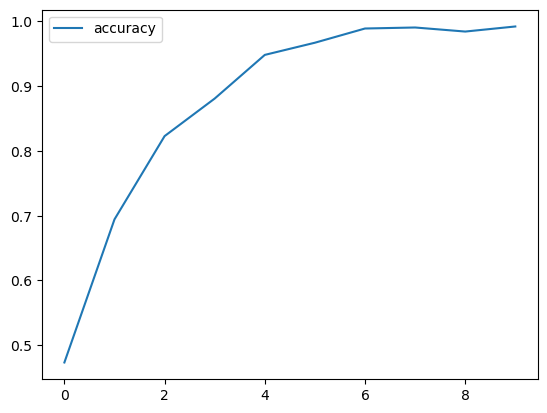

In [95]:
plt.plot(model.history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

In [96]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)
print(f'The accuracy is {accuracy}')
print(f'The loss is {loss}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 73s 14s/step - accuracy: 0.7911 - loss: 0.5928
The accuracy is 0.824999988079071
The loss is 0.5324912071228027


In [97]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 71s 14s/step


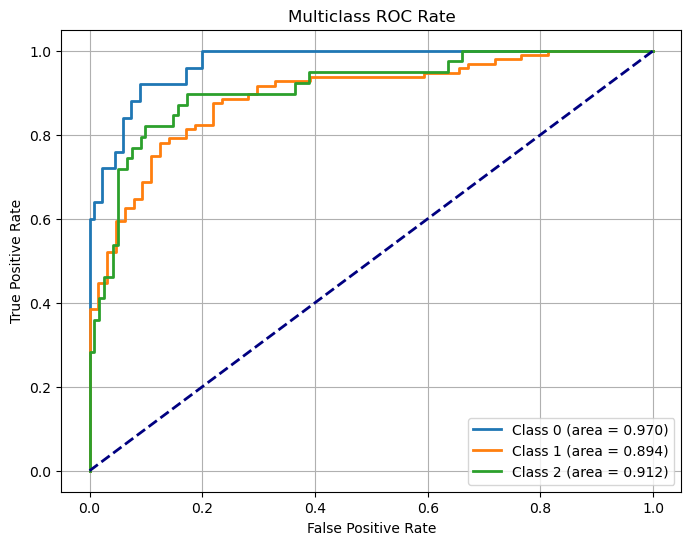

AUROC for class Normal : 0.970
AUROC for class Benign : 0.894
AUROC for class Malignant : 0.912


In [98]:
y_true = y_test
n_classes = y_true.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i],  _ =  roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i],tpr[i])

plt.figure(figsize=(8,6))
for i in range(n_classes):
    plt.plot(
        fpr[i], tpr[i], 
        lw=2,
        label=f"Class {i} (area = {roc_auc[i]:.3f})"

    )

plt.plot([0,1], [0,1], color="navy", lw=2, linestyle= "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()
classes_names = {0:"Normal", 1:"Benign", 2:"Malignant"}
for i in range(n_classes):
    print(f"AUROC for class {classes_names[i]} : {roc_auc[i]:.3f}")


In [99]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 400, 400, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 400, 400, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 400, 400, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 200, 200, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 200, 200, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 200, 200, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 100, 100, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 100, 100, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 100, 100, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 100, 100, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 50, 50, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 50, 50, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 50, 50, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 50, 50, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 25, 25, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,340,875 (272.14 MB)

 Trainable params: 18,875,395 (72.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 37,750,792 (144.01 MB)

In [100]:
model.save("breast_uss_normal_bening_malignant_vgg16_model.keras")

In [101]:
from tensorflow.keras.models import load_model
model = load_model("breast_uss_normal_bening_malignant_vgg16_model.keras")